# Optimización de parámetros de modelos de aprendizaje profundo utilizando Particle Swarm Optimization

## Importaciones

- numpy
- tensorFlow 
- Keras
- Optunity
- Entre otras

Se agrega la configuración necesaria para que el experimento sea reproducible, informacion obtenida de la pagina oficial de Keras (https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development). Para que el resultado sea exactamente el mismo en todas las ejecuciones no es posible utilizar paralelismo, esto hace que el tiempo de ejecución aumente demasiado. Sin embargo, la diferencia entre experimentos al utilizar paralelismo es baja (tercer digito) por lo que se decidio aceptar esta diferencia y reducir los tiempos de computo.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(1234)
import random as rn
rn.seed(12345)
import os
os.environ['PYTHONHASHSEED'] = '0' 
from keras import backend as K

import math
import time
from datetime import timedelta
#from utilities import *
import optunity
import optunity.metrics
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.optimizers import Adam

In [24]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def print_accuracy():   
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## MNIST Dataset

Se utiliza el conjunto de datos MNIST, el cual contiene 70.000 imagenes de 28x28 pixeles y las etiquetas correspondientes. Cada una de las imagenes contiene un número del 0 al 9 dibujado a mano, la etiqueta es un vector de 10 elementos con un uno en la ubicación (indice) que se corresponde con el valor representado en la imagen y los demas elementos en cero (codificacion "one-hot").

Este conjunto de datos se divide en tres subconjuntos:

- Entrenamiento
- Test
- Validación

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.array([label.argmax() for label in data.test.labels])
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## <a name="inData"></a> Dimnsiones de los datos 

Estas variables son utilizadas a lo largo del código y definen las dimensiones de los datos.

In [4]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

En el archivo "utilities.py" importado al inicio se implementaron funciones para imprimir imagenes en forma sencilla. A continuación se usan algunas de estas funciones para mostrar el set de datos que se esta utilizando.

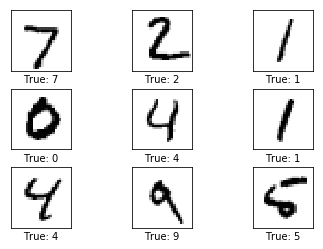

In [6]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# TensorFlow


The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

Además, TensorFlow puede calcular autmáticamente los gradientes necesarios para optimizar las variables de los grafos y mejorar la performance del modelo. Esto se debe a que los grafos son una combinación de expresiones matemáticas simples, por lo que el gradiente del grafo se obtiene mediante la _chain rule_ de las derivadas.

Un grafo de TensorFlow consiste de las siguientes partes:

- Variables _placeholder_: usadas para la entrada de datos al grafo.
- Variables del modelo: son aquellas que se modifican durante la optimización del moderlo.
- El modelo es esencialmente una funcion matemática que calcula la salida dados los datos entrada, las variables _placeholder_ y las variables del modelo.
- La funcion de costo se utiliza para guiar la optimización de las variables.
- Un método de optimización que actualiza las variables del modelo.

## Variables _Placeholder_

Las variables _placeholder_ sirven de entrada al grafo y se modifican cada vez que se ejecuta el mismo. En este caso de ejemplo, las variables _placeholder_ son las imágenes de entrada tratadas como tensores. El tipo de datos se fija a _float32_ y la forma se configura como: $ [None, img\_size\_flat] $ donde _None_ significa que el tensor puede almacenar un numero arbitrario de imagenes donde cada una es un vector de tamaño $img\_size\_flat$.

In [7]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Lo siguiente es crear una variable _placeholder_ donde se asocia las imagenes de entradas con las etiquetas verdaderas. La forma de esta variable es $[None, num\_clases]$ lo que implica que puede almacenar un numero arbitrario de etiquetas y cada una de ellas es un vector del largo $num\_clases$, en este caso es 10.
Finalmente se crea otra variable _placeholder_ similar, donde la clase real de cada imagen esta en formato _integer_.

In [8]:
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables a optimizar del modelo

Ademas de las variables de _placeholder_ se deben definir variables que se utilizaran para modificar y optimizar el modelo a partir de los datos de entrenamiento. Estas variables, llamadas _weights_ (pesos) y _biases_ (sesgo), se explicaraán en detalle en la siguiente sección. 

La forma de la variable de pesos es $[img\_size\_flat, num\_classes]$, es decir, es un tensor de dos dimensiones con $img\_size\_flat$ filas y $num\_classes$ columnas. La variable llamada vias es un tensor de una dimensión de largo $num\_classes$.

In [9]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

## Modelo: Score function

Esta es una función que indica la calidad de la clasificación de un dato determinado para cada una de las categorias disponibles. Si se asume que el conjunto de entrenamiento contiene $x_i \in R^D$ cada uno asociado a una etiqueta $y_i$, siendo $i = 1 \, ... \, N$ y que $y_i \in 1 \, ... \, K$. Entonces, se tienen $N$ ejemplos de dimension $D$ y $K$ categorias. 
Por ejemplo, en el conjunto de datos de entrenamiento de MNIST se tienen $N = 55000$ imágenes, cada una de $D = 28 x 28 = 784$ pixeles. Debido a que existen 10 categorias (0 al 9), $K=10$. 

Se define a la función "score" como:
\begin{equation}
f : R^D \mapsto R^K
\end{equation}
donde se mapean los datos de entrada a los "score" de cada clase. 

### Clasificador lineal

El clasificador lineal es un modelo simple donde se multiplican las imágenes en las variables _placeholder_ con los pesos (_weight_) y se les suma el sesgo (_bias_):
\begin{equation}
s = f(x_i, W,b) = Wx_i \, + \, b
\end{equation}

En el procesamiento de imagenes, $x_i$ contiene todos los pixeles de una imagen dada en la forma de vector columna $[D \, \times \, 1]$. La matriz $W$ de tamaño $[K \, \times \, D]$ son los pesos de la función y el vector de bias $b$ de tamaño $[K \, \times \, 1]$ se denomina asi por que influye en el resultado final pero sin interactuar con las entradas $x_i$. En conjunto, conforman los parámetros de la función y generalmente se combinan en una unica matrix de tamaño $[K \, \times \, (D + 1) ]$, esto hace neesario modificar el vector columna $X_i$ de la misma manera agregando la constante 1. 
 
\begin{equation}
s = f(x_i, W) = Wx_i
\end{equation}

Volviendo al ejemplo del conjunto de datos MNIST, $x_i$ es un vector columna de la forma $[785 \, \times \, 1]$ y la matriz de parametros conformada por $W$ en conjunto con $b$ tiene la forma $[10 \, \times \, 785]$. Utilizando la nomenclatura de la sección "Dimensiones de los datos" [link](#inData) la forma de las imagenes de entrada es $ x = [num\_images, img\_size\_flat ]$ y la de los pesos $W = [num\_images, num\_classes]$ por lo que el resultado tiene la forma $[num\_images, num\_classes]$ luego se suma el vector de sesgos a cada fila de la matriz.

In [10]:
logits = tf.matmul(x, weights) + biases

_logits_ es una matriz de num\_images filas y num\_classes columnas, donde el elemento de la fila $i$ y de la columna $j$ es un estimado de la probabilidad de que la imagen de entrada $i$ pertenezca a la clase $j$. 
Nota: el nombre logits es tipico de la terminologia de _TensorFlow_.

Se puede ver que a partir de la multiplicación de matrices $W \; x_i$ efectivamente se estan evaluando 10 clasificadores en paralelo (uno por clase) donde cada clasificador es una fila de $W$. Además, aunque $(x_i,y_i)$ son fijos, se pueden modificar los parametros $W,b$ hasta obtener valores de "score" que coincidan con la tabla de verdad durante el entrenamiento. Es decir, los parametros $(W,b)$ se aprenden durante el entrenamiento, pero cuando este finaliza, los datos de entrada pueden descartarse y unicamente mantener dichos parametros.


Sin embargo, estos valores estimados son algo complicado de interpretar por que los numeros son demasiado grandes o demasiado chicos. Por lo que se busca normalizar cada fila de la matriz _logits_ para que sume 1 y cada valor este limitado entre cero y uno. Para esto se utiliza la función _softmax_ que se explica en la siguiente sección.

### Softmax

El resultado de la clasificación _softmax_ puede interpretarse como la propabilidad logaritmica no normalizada de que un dato pertenezca a una clase dada. Por lo tanto, para obtener la probabilidad normalizada, es necesario exponenciar el score y dividirlo por el score total:

\begin{equation}
P(y_i \; | \; x_i ; W) = (\frac{e^{s_k}}{\sum_{j}e^{s_j} }) 
\end{equation}

Considerando que $s_j$ es el "score" que se obtiene para la clase j del elemento i: $s_j = f(x_i,W)_j$. Al sumar todas las probabilidades de un elemento frente a las distintas clases se obtiene uno, por esto se dice que está normalizada.

Se aplica la función _softmax_ al conjunto de datos utilizado _MNIST_

In [11]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Función de pérdida (_loss_) a optimizar

La función de perdida cuantifica las diferencias entre las categorias estimadas y las categorias verdaderas. Intuitivamente, la perdida o costo va a ser alta si la clasificación del conjunto de entrenamiento es mala y baja si es buena. Existen distintos métodos para calcular la perdida, los dos mas utilizados son SVM (Multiclass Support Vector Machine) y Softmax.

La funcion softmax (idealmente) nos devolvería una probabilidad de uno para la clase verdadera y probabilidad cero para las demás (falsas). Sin embargo, se necesita un unico valor que represente que tan mal se esta clasificando el conjunto de entrenamiento, por lo que se aplica la _cross-entropy_ a la función softmax.

La entropía cruzada entre la distribución "verdadera" $p$ y la obtenida mediante la función softmax $q$ se define como:

\begin{equation}
H(p,q) = - log({\sum_{x}p(x) \; log \, q(x) }) \\
q = \frac{e^{s_k}}{\sum_{j}e^{s_j} })
\end{equation}

La entropia cruzada es una funcón cuyo resultado es siempre positivo y si la predicción del modelo es identica a la salida deseada, la entropia cruzada es cero. Es también pensar la entropia cruzada, en este campo, como la distancia entre ambas distribuciones.

\begin{equation}
L_i = - log(\frac{e^{s_k}}{\sum_{j}e^{s_j} })
\end{equation}

En la siguiente imagen puede verse un ejemplo numérico: 

<img src="images/softmax.png" width="60%">

En la práctica, los términos $e^{s_k}$ y $\sum_{j}e^{s_j}$ pueden volverse muy grandes debido a los exponenciales. Sin embargo, dividilos puede ser numéricamente inestable. Es importante utilizar algun tipo de normalización, por lo general se multiplican ambos términos por una constante $C$:

\begin{equation}
(\frac{e^{s_k}}{\sum_{j}e^{s_j} }) = (\frac{C \, e^{s_k}}{C \, \sum_{j}e^{s_j} }) = (\frac{e^{s_k + log C}}{\sum_{j}e^{s_j + log C} })
\end{equation}

C puede ser cualquier valor y se obtendrá el mismo resultado, pero se puede utilizar para mejorar la estabilidad computacional. Una elección común es $log C = -max_j f_j$. De esta forma, se desplazan todos los valores de forma tal en que el mayor termina siendo $0$.

In [12]:
f = np.array([123, 456, 789]) # example with 3 classes and each having large scores
p = np.exp(f) / np.sum(np.exp(f)) # Bad: Numeric problem, potential blowup
print(p)
# instead: first shift the values of f so that the highest number is 0:
f -= np.max(f) # f becomes [-666, -333, 0]
p = np.exp(f) / np.sum(np.exp(f)) # safe to do, gives the correct answer
print(p)

[  0.   0.  nan]
[  5.75274406e-290   2.39848787e-145   1.00000000e+000]


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


#### Regularización

Con el objetivo de diferenciar distintos conjuntos de parámetros que den como resultado perdidas $L$ similares, se agrega un término denominado "pérdida de regularización":

\begin{equation}
L = \frac{1}{N} \; \sum_{i} \; L_i \; + \; \lambda R(W)
\end{equation}

Existen distintos métodos para realizar esta penalización, uno de los mas utilizados es la norma L2:

\begin{equation}
R(W) = \sum_{k} \sum_{l} W^2_{k,l}
\end{equation}

Como puede verser en la formula anterior, el objetivo es penalizar los pesos $W$ grandes por sobre los pequeños. Esto implica una mayor generalidad en el algoritmo, ya que, ninguna dimensión de entrada puede llegar a tener una influencia demasiado grande en los score por si sola. Como se prefieren pequeñas ponderaciones en todas las dimenciones frente a algunas pocas muy fuertes, esto disminute la tendencia al overfitting. 
Ejemplo: 

Si se considera la sigunte entrada $x$ y dos pesos $w_1$ y $w_2$:
\begin{align}
x &= [1,1,1,1]\\
w_1 &= [1,0,0,0]\\
w_2 &= [0.25,0.25,0.25,0.25]\\
w_1^T &= w_2^T = 1\\
\end{align}

Como puede verse, todos llevan la misma pérdida, sin embargo, la penalidad **L2** debida al peso $w_1$ es 1 mientras que la debida al $w_2$ es 0.25.

$\lambda$ es un hiperparámetro que pondera la perdida. Es dificil de predecir y por lo general se obtiene mediante cross-validation. Como se mencionó anteriormente, la función softmax provee las "probabilidades" para cada clase, sin embargo, estas probabilidades pueden ser mas difusas o abruptas dependiendo del coeficiente de regulación $\lambda$. Por ejemplo, si se supone que las porbabilidades logaritmicas no regularizadas para tres categorias son $[1, -2, 0]$, con la funcion softmax se calcularía:

\begin{equation}
[1, -2, 0] \rightarrow [e^1, e^{-2}, e^0] = [2.71,0.14,1] \rightarrow [0.7,0.04,0.26]
\end{equation}

Ahora, si el parametro $\lambda$ se aumenta, los pesos $W$ mas grandes serían penalizados y por lo tanto, como resultado se obtendrían pesos de menor magnitud. Por ejemplo, si disminuyen a la mitad $[0.5, -1, 0]$, la funcion sofmax computaría:

\begin{equation}
[0.5, -1, 0] \rightarrow [e^{0.5}, e^{-1}, e^0] = [1.65,0.37,1] \rightarrow [0.55,0.12,0.33]
\end{equation}

Donde las probabilidades ahora son mas difusas. En el limite, donde los pesos tienden a numeros chicos debido a penalidades muy fuertes de $\lambda$, las probabilidades tienden a la uniformidad.

Agregando el término de regularización a la ecuación de pérdida, se obtiene:

\begin{equation}
L_i = - log(\frac{e^{s_k}}{\sum_{j}e^{s_j} }) + \sum_{k} \sum_{l} W^2_{k,l}
\end{equation}

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. __The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.__

TensorFlow contiene funciones para calcular la entropia cruzada. Notar que se utilizan los valores de la variable logits por que se calcula el softmax internamente. Es decir, la siguiente API aplica la función _softmax_ y la entropia cruzada al resultado de $Wx_i \, + \, b$

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

Una vez calculada la entropia cruzada para la clasificación de cada imagen, es decir, se medidó que tan bien el modelo se comporta para cada imagen individualmente. Sin embargo, se necesita un valor que pueda analizar el comportamiendo del modelo para todo el conjunto de entrenamiento. Entonces, simplemente se obtiene la media de la entropia cruzada de cada imagen:

In [14]:
cost = tf.reduce_mean(cross_entropy)

## Optimización

A partir de las funciones de _score_ y _loss_, es necesario generar un proceso para elegir el conjunto de parámetros $W$ que minimice la función de pérdida. La optimización es un proceso estocastico e iterativo, donde en cada paso se intenta minimizar la función de pérdida. Para computar la mejor dirección en la que se debe modificar el conjunto de parámetros $W$ y así minimizar la función de pérdida, se utiliza el gradiente de la función de perdida. En una dimensión, la pendiente de la función es el ritmo de cambio instantaneo en cualquier punto, el gradiente es una generalizacion de la pendiente para funciones con más de una dimensión. El gradiente es un vector de pendientes para cada dimencion en el espacio de entrada (vector de derivadas parciales).

### Gradient Decent

Obtener el gradiente de la función de perdidas implica obtener la derivada parcial respecto a cada uno de los parametros $W$. El procedimiento de evaluar el gradente y luego actualizar los parametros se denomina _Gradient Descent_. El siguiente codigo muestra una versión simplificada (_vanilla_) del _loop_ que se encuentra en el código de todas las bibliotecas de redes neuronales. 

Cuando el conjunto de entrenamiento es muy grande, es muy costoso evaluar la funcion de perdida en todos los datos unicamente para actualizar los parámetros. Una aproximación muy utilizadas es computar el gradiente para un lote aleatorio de datos que cambia en cada iteración (_Minibatch Gradient Descent_). El tamaño de este lote es un hiperparametro, pero no es comun que se obtenga por validación cruzada, sino por la limitación de memoria disponible.

<img src="images/opt1.gif" width="40%">
<img src="images/opt2.gif" width="40%">

Image credit: Alec Radford (https://twitter.com/alecrad)

## Backpropagation

Como se mencionó anteriormente, para poder aplicar _Gradient Decent_ es necesario contar con el gradiente de la función de pérdidas, ya que es la forma más eficiente de aplicar este algoritmo de optimización. Sin embago, para algunas funciones de pérdidas, esto puede ser dificil de resolver. _Backpropagation_ es una forma de computar gradientes de expresiones a través de la aplicación de la _chain rule_, donde complejas funciones se resuelven dividiendolas en explresiones más sencillas hasta que cada una de ellas es fácil de resolver.
Si se considera la expresión $f(x,y,z) = (x + y)z$ a modo de ejemplo, lo primero que se hace es dividirla en dos más sencillas: $q = x + y$ y $f = qz$. Calcular las derivas de ambas expresiones por separado es sencillo: $\frac{\partial f}{\partial q} = z$ y $\frac{\partial f}{\partial z} = q$

In [15]:
# set some inputs
in_x = -2; in_y = 5; in_z = -4

# perform the forward pass
q = in_x + in_y # q becomes 3
f = q * in_z # f becomes -12
print("q = " + str(q) + "\nf = " + str(f))
# perform the backward pass (backpropagation) in reverse order:
# first backprop through f = q * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = in_z # df/dq = z, so gradient on q becomes -4
print("df/dz = " + str(dfdz) + "\ndf/dq = " + str(dfdq))
# now backprop through q = x + y
dfdx = 1.0 * dfdq # dq/dx = 1. And the multiplication here is the chain rule!
dfdy = 1.0 * dfdq # dq/dy = 1
print("df/dx = " + str(dfdx) + "\ndf/dy = " + str(dfdy))

q = 3
f = -12
df/dz = 3
df/dq = -4
df/dx = -4.0
df/dy = -4.0


In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

Function for performing a number of optimization iterations so as to gradually improve the weights and biases of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [17]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

## Sesión de TensorFlow 


Es importante notar que hasta ahora no se corrió nada de TensorFlow, unicamente se agregaron los objetos al grafo de TensorFlow para ejecutarlo luego. Para poder ejecutarlo, es necesario primero crear una sesión e inicializar las variables de pesos y sesgos.

Accuracy on test-set: 9.8%


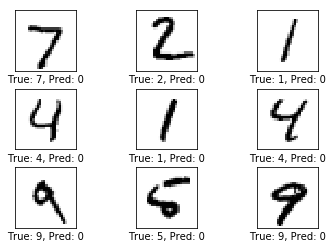

Accuracy on test-set: 36.5%


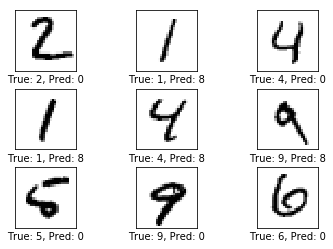

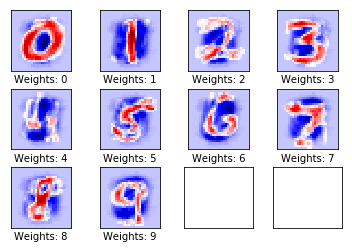

In [19]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

session = tf.Session()
session.run(tf.global_variables_initializer())
batch_size = 100

print_accuracy()
plot_example_errors()
optimize(num_iterations=1)
print_accuracy()
plot_example_errors()
plot_weights()

#Importante: En el PSO tengo que usar si o si cross validation! Ver la pagina de Optunity 

Cada nodo en el grapho representa una operación matemática, mientras que los bordes del grafico representan vectores de datos (tensores) que se comunican a traves de los nodos.